In [2]:
from parameters import parameters as par
from model import Model
from modules.loader import Loader

#import pickle

In [8]:
V_sol, C_sol = Model().solve(par)

/Users/Jeppe/.local/share/virtualenvs/dypa_termpaper-laBhpRgB/lib/python3.7/site-packages/scipy/optimize/_minimize.py:761: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/Users/Jeppe/.local/share/virtualenvs/dypa_termpaper-laBhpRgB/lib/python3.7/site-packages/scipy/optimize/_minimize.py:761: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [9]:
Loader.save(V_sol, C_sol, par, file_prefix='lars')

In [10]:
V_sol, C_sol, par_ = Loader.load(file_prefix='lars')

In [86]:
import numpy as np
from model import Model
from agent import update_f, calc_a, R_tilde
from modules.interp import Interpolate3D, Majority3D
from modules.meshmapping import create_lookup_dict, create_mesh
from modules.stategrid import create_statespace, create_m_grid, create_f_grid, create_p_grid

class Simulator(Model):
        
    NUMPY_SEED = 43
    SHOCK_SCALE = 0.1
    KAPPA_SCALER = 1.8182

    
    @classmethod
    def simulate(cls, V_sol, C_sol, par, n_persons=1):
        
        np.random.seed(cls.NUMPY_SEED)
        timesteps =  par.max_age - par.start_age + 1
        shocks = np.exp(np.random.normal(size=(3,timesteps,n_persons), scale=cls.SHOCK_SCALE))
        choices = np.empty(shape=(3,timesteps,n_persons))
        states = np.empty(shape=(3,timesteps,n_persons))
        
        #notes on subsetting:
        # [variables, timestep_index (ix NOT t), person_ix]
        
        #letting the first state be said
        for pix in range(n_persons):
            states[0, 0, pix], states[1, 0, pix], states[2, 0, pix] = 100000, 0, 1

        m_grid = create_m_grid(par)
        p_grid = create_p_grid(par)
        f_grid = create_f_grid(par)
        statespace = create_statespace(par)
       
        m, f, p = 2, 0, 0 #cannot start with zero income
        
        for ix, t in enumerate(range(par.start_age, par.max_age + 1)):
            
            print("In period: ", t, "ix: ", ix)
            
            #interpolators
            interp_c, interp_kappa, interp_i = cls.create_interpolators(C_sol,
                                                                        t, 
                                                                        statespace, 
                                                                        m_grid, 
                                                                        f_grid, 
                                                                        p_grid,
                                                                        par
                                                                       )
                                                                        
            
            for person_ix in range(n_persons):
                
                #subsetting the persons shock
                psi, xi, eps = shocks[:,ix,person_ix]
                
                #subsetting the persons states:
                m, f, p = states[:,ix,person_ix]
                
                c = interp_c.interpolate(m, f, p)
                kappa = interp_kappa.interpolate(m, f, p) 
                i = interp_i.interpolate(m, f, p)
                
                try:
                    m_fut, f_fut, p_fut = cls.upd_stts(t, m, f, p, c, kappa, i, psi, xi, eps, par)
                except:
                    return states, choices
                
                states[:,ix + 1, person_ix] = m_fut, f_fut, p_fut
                choices[:, ix, person_ix] = c, kappa, i
                
                
                
        return interp_c
                
    @classmethod
    def create_interpolators(cls, C_sol, t, statespace, m_grid, f_grid, p_grid, par):
        choices_c = C_sol[t][:,0]
        choices_kappa = C_sol[t][:,1]
        choices_i = C_sol[t][:,2]
        
        ld_c = create_lookup_dict(statespace, choices_c)
        ld_kappa = create_lookup_dict(statespace, choices_kappa)
        ld_i = create_lookup_dict(statespace, choices_i)
        
        mesh_c = create_mesh(m_grid, f_grid, p_grid, ld_c, par)
        mesh_kappa = create_mesh(m_grid, f_grid, p_grid, ld_kappa, par)
        mesh_i = create_mesh(m_grid, f_grid, p_grid, ld_i, par)
        
        interp_c = Interpolate3D(m_grid, f_grid, p_grid, mesh_c)
        interp_kappa = Majority3D(m_grid, f_grid, p_grid, mesh_kappa, 0, 0.55)
        interp_i = Majority3D(m_grid, f_grid, p_grid, mesh_i, 0, 1)
        
        return interp_c, interp_kappa, interp_i
    
    @classmethod
    def upd_stts(cls, t, m, f, p, c, kappa, i, psi, xi, eps, par):
        
        "Update states -> dynamic of model"
        f = update_f(i, f, par) # updateting to f_t+1
        assets = calc_a(c, i, kappa, m, par)

        interest_factor = R_tilde(kappa, f, par, shock=eps)
        income = xi * (par.G * p * psi) + par.age_poly[t]

        # Future state values
        m_fut = interest_factor * assets + income
        p_fut = par.G * p * psi
        f_fut = np.float64(f)
       
        print(m - c)
        print(assets * interest_factor)
        #print(p, psi, par.G)
        #print(p_fut)
        #print(income)
        #print(par.age_poly[t])
        
        return m_fut, f_fut, p_fut

In [87]:
states, choices = Simulator.simulate(V_sol, C_sol, par, 1)

In period:  75 ix:  0
11628.918064293917
11732.419121361747
In period:  76 ix:  1
0.00017731474508764222
-51.621765640009826
In period:  77 ix:  2
-2.472182529800193e-07
-50.06137634212311
In period:  78 ix:  3
-2.247357997475774e-07
-56.260919239256644
In period:  79 ix:  4
-3.1860142257755797e-07
-45.97499015077088
In period:  80 ix:  5
-1.6134680436152848e-07
-55.49010011409021
In period:  81 ix:  6
-3.0551878182905057e-07
-49.415579881811716
In period:  82 ix:  7
-2.0954954749186072e-07
-55.99268831000395
In period:  83 ix:  8
-3.0971312980909715e-07
-55.026806407973666
In period:  84 ix:  9
-2.920446604548488e-07
-54.405565122243296
In period:  85 ix:  10
-2.8189752754315123e-07
-53.85484243196429
In period:  86 ix:  11
-2.761725141908755e-07
-58.67001097039013
In period:  87 ix:  12
-3.4659849035278967e-07
-49.80706351320779
In period:  88 ix:  13
-2.1641442060627014e-07
-49.86819341370827
In period:  89 ix:  14
-2.1802333804998852e-07
-49.691285925326916
In period:  90 ix:  15


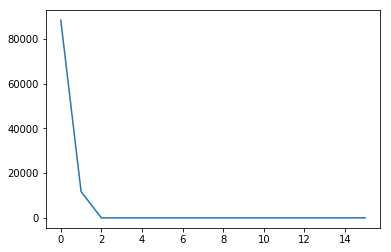

In [80]:
import matplotlib.pyplot as plt
plt.plot(choices[0,:])

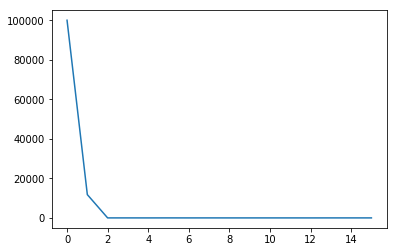

In [81]:
plt.plot(states[0,:])